In [21]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from qbo1d.stochastic_forcing import sample_sf_cw

from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
x = np.linspace(-30, 30, 10000)
y = np.sin(np.cos(x))
x = x.reshape(-1, 1)

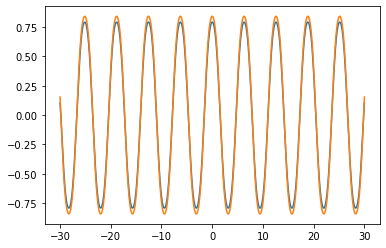

In [33]:
svr = SVR(kernel='rbf', gamma='auto', epsilon=.05)

svr.fit(x, y)
plt.plot(x, svr.predict(x), label='svr')

plt.plot(x, y)


In [24]:
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1])
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def gen_normal(self,n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def stock_price(
                    self,
                    s0=100,
                    mu=0.2,
                    sigma=0.68,
                    deltaT=52,
                    dt=0.1
                    ):
        """
        Models a stock price S(t) using the Weiner process W(t) as
        `S(t) = S(0).exp{(mu-(sigma^2/2).t)+sigma.W(t)}`
        
        Arguments:
            s0: Iniital stock price, default 100
            mu: 'Drift' of the stock (upwards or downwards), default 1
            sigma: 'Volatility' of the stock, default 1
            deltaT: The time period for which the future prices are computed, default 52 (as in 52 weeks)
            dt (optional): The granularity of the time-period, default 0.1
        
        Returns:
            s: A NumPy array with the simulated stock prices over the time-period deltaT
        """
        n_step = int(deltaT/dt)
        time_vector = np.linspace(0,deltaT,num=n_step)
        # Stock variation
        stock_var = (mu-(sigma**2/2))*time_vector
        # Forcefully set the initial value to zero for the stock price simulation
        self.x0=0
        # Weiner process (calls the `gen_normal` method)
        weiner_process = sigma*self.gen_normal(n_step)
        # Add two time series, take exponent, and multiply by the initial stock price
        s = s0*(np.exp(stock_var+weiner_process))
        
        return s

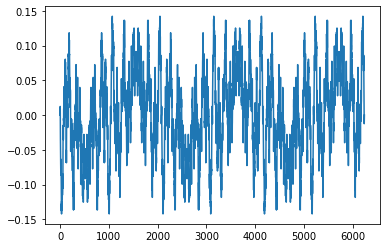

In [35]:
y_ = Brownian().stock_price(s0=0.5) - 0.5
y__ = np.concatenate([y_, np.flip(y_)])
y = np.concatenate([y__, -y__, y__, -y__,y__, -y__])
plt.plot(y)


In [40]:
x = np.linspace(-250, 150, len(y)).reshape(-1, 1)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

0.9239123509381667

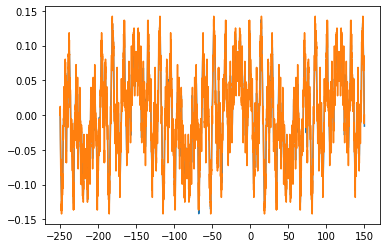

In [43]:
svr = SVR(kernel='rbf', gamma='auto', epsilon=.01)
svr.fit(x_train, y_train)
plt.plot(x, svr.predict(x))
plt.plot(x, y)
svr.score(x_test, y_test)

In [29]:
# Here we can see svr can deal with non-linearity
# Though it is not that good in a microscopic view

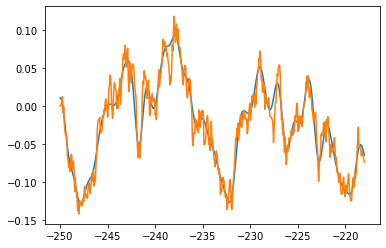

In [44]:
plt.plot(x[:500], svr.predict(x)[:500])
plt.plot(x[:500], y[:500])
